In [1]:
#make IPython notebook matplotlib plot inline
%matplotlib inline 

#import modules and libraries
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from pathlib import Path
from PIL import Image
from scipy import ndimage
from skimage import measure
from skimage.io import imread,imsave

INPUT_DIR = '/mnt/med-groups-lmu/ls1/users/j/jilehtim/HARRI/PYTHON_INPUT'
OUTPUT_DIR = '/mnt/med-groups-lmu/ls1/users/j/jilehtim/HARRI/PYTHON_OUTPUT'

INPUT_DIR = Path(INPUT_DIR)
if not INPUT_DIR.is_dir():
    raise ValueError('Please check INPUT_DIR.')

OUTPUT_DIR = Path(OUTPUT_DIR)
if not OUTPUT_DIR.is_dir():
    raise ValueError('Please check OUTPUT_DIR.')

MIN_FRAMES = 4


ModuleNotFoundError: No module named 'PIL'

In [36]:

def process(file):
    print(str(file))
    im = imread(str(file), plugin="tifffile")
    print(im.shape)
    print(im.dtype)

    # select white pixels into blobs
    blobs = im == 255
    # label blobs
    labels = measure.label(blobs)
    # measure labeled blobs
    props = measure.regionprops_table(labels)
    # read measurements into a dataframe
    df = pd.DataFrame(props)
    # add column for and calculate blink duration
    df['duration'] = df['bbox-3'] - df['bbox-0']

    print(df.shape)
    print(df.head())

    # filter out short blinks
    df = df[df['duration'] >= MIN_FRAMES]
    print(df.shape)
    long_blinks = df.label.values
    print(long_blinks)

    # set label to zero in labels image if the label is not in long_blinks
    ul = np.unique(labels)
    for l in ul:
        if l not in long_blinks:
            labels[labels==l] = 0

    # save modified labels image
    from skimage import img_as_uint
    labels = img_as_uint(labels)
    output = OUTPUT_DIR / (file.stem + '_long_blinks.ome.tif')
    print(str(output))
    imsave(str(output),labels)

    # save measurements
    output = OUTPUT_DIR / (file.stem + '_long_blinks.csv')
    print(str(output))
    df.to_csv(output, index=False)
    
    return labels
    
    
# process all .ome.tif files in input directory    
files = INPUT_DIR.glob('*.ome.tif')
labels = None
for f in files:
    FILE = DATA_DIR / f
    if not FILE.exists():
        raise ValueError('Please check FILE_NAME.')
    labels = process(f)

   
    
    

PYTHON_INPUT/timetubes2.ome.tif
(181, 1024, 1024)
uint8
(43, 8)
   label  bbox-0  bbox-1  bbox-2  bbox-3  bbox-4  bbox-5  duration
0      1       5     568     704       6     584     718         1
1      2       7     568     704       9     584     718         2
2      3      21     628     697      23     644     711         2
3      4      22     592     718      23     608     732         1
4      5      22     628     669      23     644     683         1
(10, 8)
[ 6  7 13 16 18 21 23 27 35 41]


/home/hajaalin/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:454: UserWarning: Downcasting int64 to uint16 without scaling because max value 41 fits in uint16
  return convert(image, np.uint16, force_copy)


PYTHON_OUTPUT/timetubes2.ome_long_blinks.ome.tif


/home/hajaalin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: PYTHON_OUTPUT/timetubes2.ome_long_blinks.ome.tif is a low contrast image


PYTHON_OUTPUT/timetubes2.ome_long_blinks.csv


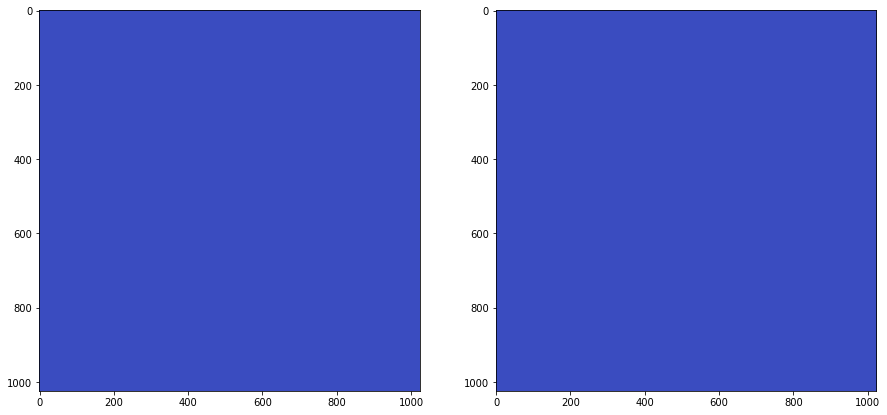

In [38]:
z=35
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(labels[z],cmap='coolwarm')
axs[1].imshow(labels[z],cmap='coolwarm')

In [25]:
help(imsave)

Help on function imsave in module skimage.io._io:

imsave(fname, arr, plugin=None, check_contrast=True, **plugin_args)
    Save an image to file.
    
    Parameters
    ----------
    fname : str
        Target filename.
    arr : ndarray of shape (M,N) or (M,N,3) or (M,N,4)
        Image data.
    plugin : str, optional
        Name of plugin to use.  By default, the different plugins are
        tried (starting with imageio) until a suitable
        candidate is found.  If not given and fname is a tiff file, the
        tifffile plugin will be used.
    check_contrast : bool, optional
        Check for low contrast and print warning (default: True).
    
    Other parameters
    ----------------
    plugin_args : keywords
        Passed to the given plugin.
    
    Notes
    -----
    When saving a JPEG, the compression ratio may be controlled using the
    ``quality`` keyword argument which is an integer with values in [1, 100]
    where 1 is worst quality and smallest file size, 